# Lesson 18: 

## SGD 

* First part of lesson goes through SGD, Momentum, RMSProp, Adam and Adam with annealing using a spreadsheet (graddesc.xlsm). 

* Adam works so much better it is quite suprising to me. After one or two runs you have to lower the learnign rate to keep it from bouncing around.

* Adam with annealing attempts to reduce the learning rate as the training progresses.
    * Keeps track of lowest squared gradient.
    *  If the current squared gradient is more than 1/2 the lowest, then it reduces the learning rate by a factor of 4.
    * This was implemented in VBA code in the spreadsheet. Works quite well! 


## Accelerated SGD 

* Notebook #12, same as last time but now up to the Schedulers section

In [1]:
import torch
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

Jeremy makes the point that we already know how to modify the learning rate, we did this with the learning rate finder. So we are not going to reimplement the schedulers from scratch, instead use the predified schedulers in PyTorch.

In [3]:
# lets see whats available, looking only ot stuff with CamelCase
' '.join([o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower()])

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

Let's experiment with Consine Annealing..  but first lets see whats in the pytorch optimizer so we can figure out how to get these schedulers working

In [3]:
# note: The devicecb is required. This seems like a bug in our code. We should default to
# CPU or something.
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=0.01, cbs = [DeviceCB(), SingleBatchCB()])
learn.fit(1) # need to run at least one epoch to get the optimizer
opt = learn.opt
opt

# at 27 minutes only

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

The optimizer repr gives you the configuration of the optimzer in a paramter group.  
The optimzer also has a state dict that contains the state of the optimizer (and the current parameters of the model. )

In [4]:
param = next(iter(learn.model.parameters()))

[Parameters](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) wrap the tensor (and are a special  kind of tensor)

In [5]:
st = opt.state[param] # this must look up the state of the parameter object by its hash (i.e. id)? I.e. the parameter object, even though the values can change.

In [6]:
# state of the optimizet is stored this way.. not as attributes as we did. 
st

{'momentum_buffer': None}

Optimizer parameters are stored in groups.  We will see later that this is useful for different learning rates for different layers (for example)

In [7]:
list(opt.param_groups[0])

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable',
 'fused']

Ok lets look at at a cosine annealing scheduler

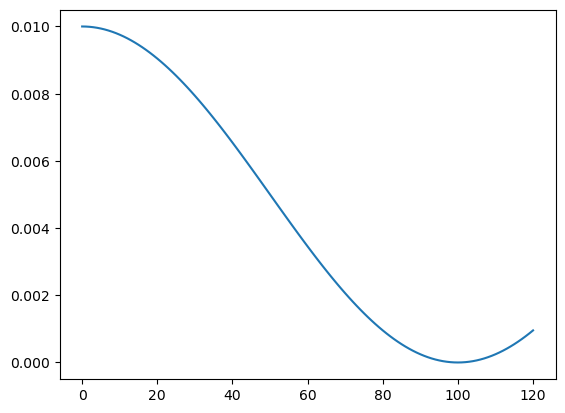

In [8]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100) #  Second argument is T_max, the number of iterations to go from the initial lr to the final lr, which defaults to 0.

# Plot it
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for _ in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

sched_lrs(sched, 120)

### Schedular call back. 

This will use a schedular to change the learning rate using a callback in our learner.

In [9]:

class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

# if you   want learning rates to change after each batch, you can use the following
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [10]:
# A callback that can be used to record the learning rate among other things in the first parameter group

class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

# for recording the learning rate, as an example
def _lr(cb): return cb.pg['lr']

In [11]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

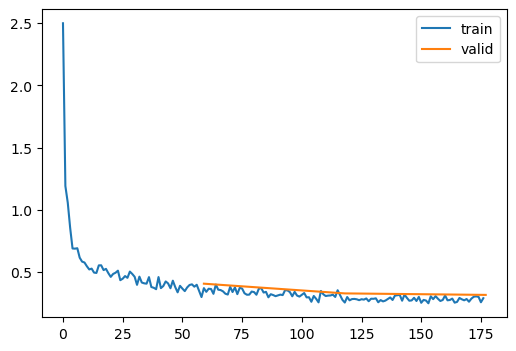

In [12]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)  # here is where _lr is used
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

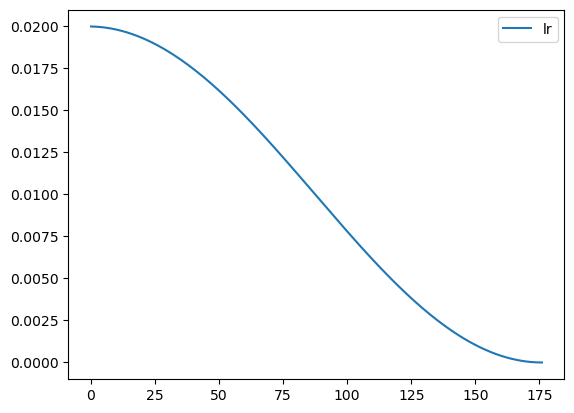

In [13]:
rec.plot()

Lets instead change only after each epoch

accuracy,loss,epoch,train
0.807,0.523,0,train
0.858,0.377,0,eval
0.880,0.327,1,train
0.869,0.338,1,eval
0.899,0.275,2,train
0.886,0.308,2,eval


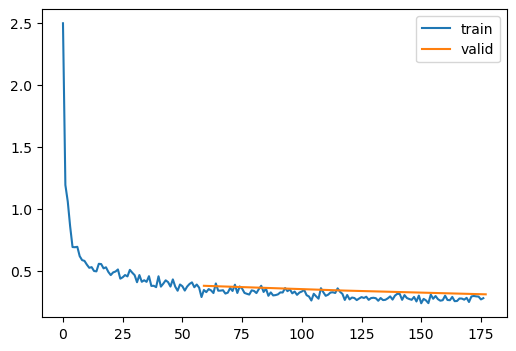

In [14]:
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3) # step at the end of each epock
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

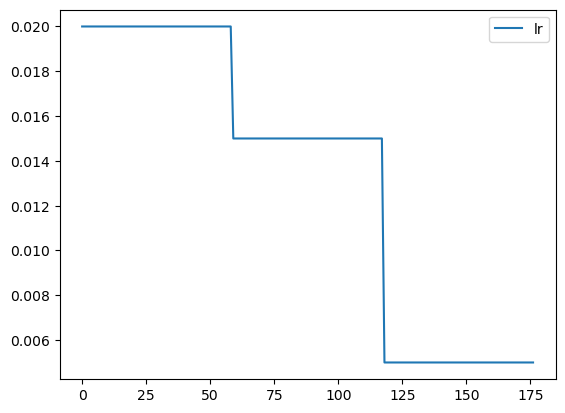

In [72]:
rec.plot()

## 1 cycle training

* was covered a bit in the first part of Fast AI.   See [paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

* I honestly could not make heads or tails of his hand waving explanation of the 1 cycle training.  I will have to read the paper.


accuracy,loss,epoch,train
0.768,0.659,0,train
0.843,0.455,0,eval
0.857,0.388,1,train
0.862,0.398,1,eval
0.886,0.307,2,train
0.884,0.327,2,eval
0.907,0.249,3,train
0.897,0.278,3,eval
0.922,0.212,4,train
0.901,0.266,4,eval


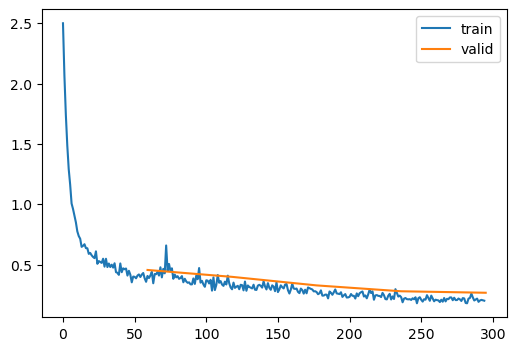

In [15]:
# record beta as well as lr 
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)


set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

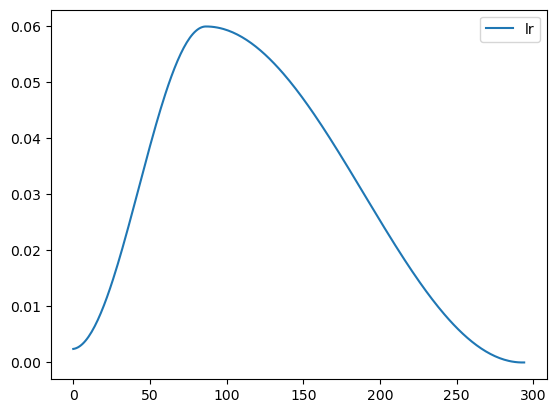

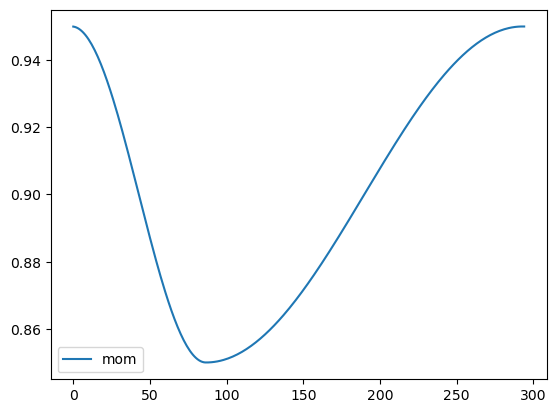

In [74]:
rec.plot()

## Changes to the previous notebooks / code
Note at this point he covers the change where they pass in the learner during the callback operation rather then saving the learner as an attribute in the callback object. We already did this since these changes were in the modified code we are using.  

Other changes:

* Added a callbacks parameter to Learner.fit to add extra callbacks.
* Added a learning rate paramter to fit to set the learning rate for one fit. 
* Added a two booleans to specify if you want to do the training, validation or both.
* Added a 'patch'  (@fc.patch) called 'lr_find' which was monkey patched into the learner class at the end of learner.py.  WHy do this instead of just adding it to the class?  Just trying to be clever? I don't know.

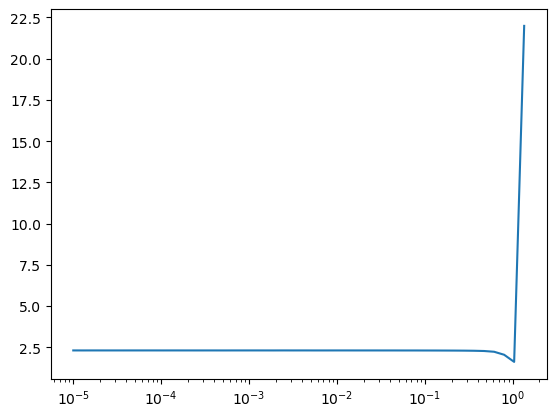

In [75]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs = cbs).lr_find()

Aside on monkey patching:

In [ ]:
Learner.poundsand = lambda self : print(f"Poundsand called on {id(self)}",self)
MomentumLearner(get_model(), dls, F.cross_entropy, cbs = cbs).poundsand()

## Resets

New Notebook from course [repo](https://github.com/fastai/course22p2) called 13_resnet.ipynb

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

# Get teh data back again

xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Set up metrics , activation function and callbacks.

In [3]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

Ok, first thing to try is just going deeper!

In [4]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.806,0.700,0,train
0.843,0.482,0,eval
0.885,0.333,1,train
0.869,0.391,1,eval
0.909,0.257,2,train
0.898,0.294,2,eval
0.927,0.207,3,train
0.904,0.264,3,eval
0.943,0.163,4,train
0.924,0.222,4,eval


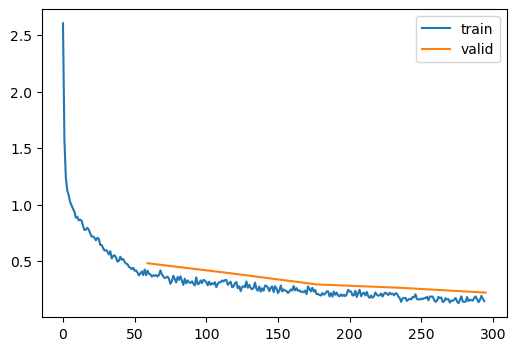

In [5]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(epochs)

Better already!  Up to 92%.    

### Skip connections

* Resnet paper : ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385).

* Going deeper eventually stops working well. For example they show a 56 layer network trains worse then a 20 layer network!  Must be a training issue.

*  One solution is to use skip connections to allow deeper leyers to learn from earlier layers (which are closer to the input). This allows the network to have a smaller network 'inside' it (following the skips). 

* Idea is to to use a block with two convs and a skip connection.  The skip connection is just the input added to the output of the block, something like this:
    
    ```
    x = self.conv(xin))
    x = self.conv(x)
    x += x_in # skip
    return F.relu(x)
    ```


* Called "residual" because the out - in is the residual which is what the block learns. 
* In typical case the out and in are not the same size, so you need to add a 'identity' conv to the skip connection to make them the same size.  

 

In [6]:

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        # idconv, tries to be a simple as possible to reduce input to output size 
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    # here is the skip
    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)


Another use of patch. 

In [7]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [8]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


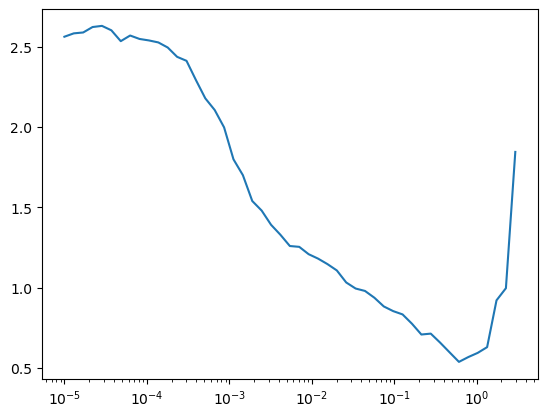

In [9]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train
0.819,0.704,0,train
0.860,0.508,0,eval
0.894,0.347,1,train
0.891,0.335,1,eval
0.917,0.251,2,train
0.886,0.341,2,eval
0.937,0.192,3,train
0.928,0.221,3,eval
0.954,0.142,4,train
0.931,0.212,4,eval


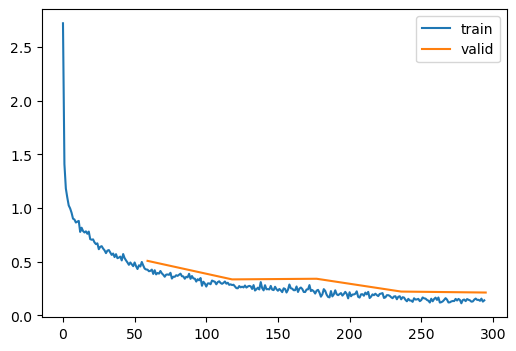

In [10]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(epochs)

93 percent!

At this point he goes through some examples using the "timm' library which has a lot of prebuilt image models.  I will skip this for now. Some insights:


* Contains many different resnet models.   

* Jeremy tried multiple resnet models from the library.  Best he found was Reset18d and he was able to get just over 92%, just a bit less then our model! 

* Encouraging that we can create good architecture just using common sense . 

## Data Augmentation 

Video at 1:23:56

* Yes we are *really* doing a third forking notebook in this lecture. 

